# GKR By Hand

## Introduction

The Goldwasser-Kalai-Rothblum (GKR) interactive proof protocol, developed by Shafi Goldwasser, Yael Tauman Kalai, and Guy N. Rothblum, provides a method for efficiently verifying the correctness of computations in a delegated computing environment. This protocol is especially useful for verifying computations on large datasets where direct verification is computationally expensive.

## Protocol Framework

The GKR protocol is based on the idea of verifying computation by checking the correctness of each step through a series of interactive proofs between a prover (who performs the computation) and a verifier (who checks the computation). The protocol uses a layered approach, where each layer of the computation is verified independently.

### Key Components

- **Circuit Representation**: The computation is represented as an arithmetic circuit.
- **Sumcheck Protocol**: A key component used in the GKR protocol to verify sums of polynomials efficiently.
- **Verifier and Prover**: Roles are defined where the prover demonstrates the correctness of their computation, and the verifier confirms this correctness through challenges and checks.

## Detailed Steps

1. **Circuit Setup**: The computation to be verified is structured as an arithmetic circuit with a hierarchical layout.
2. **Initialization**: The prover and verifier establish the initial parameters and inputs for the computation.
3. **Layer by Layer Verification**:
   - The verifier sends a random challenge related to the output of a specific layer.
   - The prover responds with a proof showing the correctness of the output for that layer.
   - The verifier checks the proof and proceeds to the next layer.
4. **Final Check**: Upon reaching the input layer, a final verification is performed to ensure all layers are computed correctly.

## Example

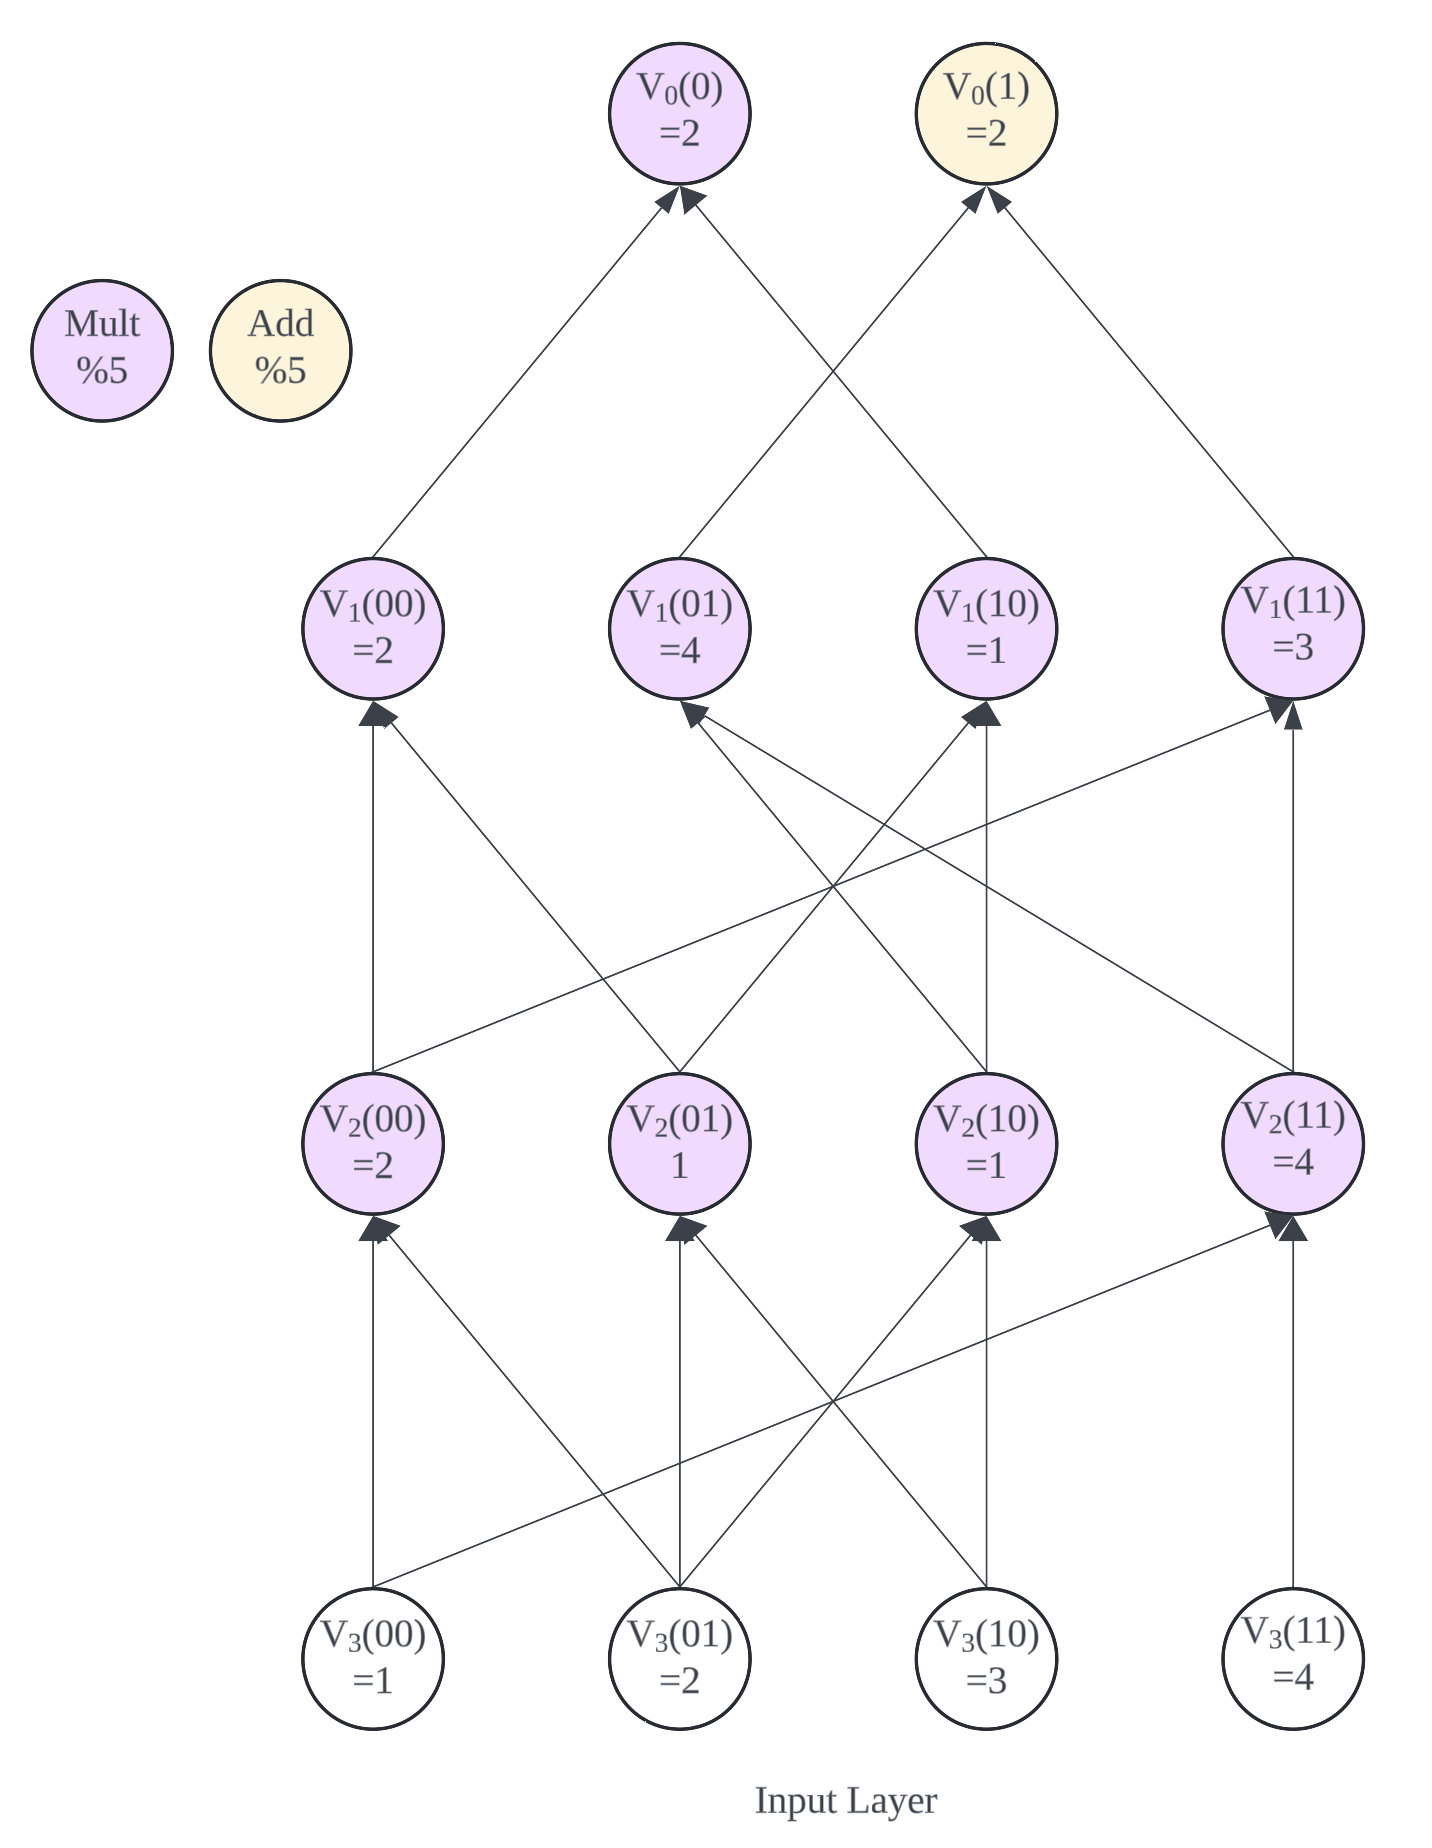

### Legend
- Circles represent Add (Addition, light yellow) or Mult (Multiplication, purple) gates.
- Each node in the circuit is labeled as `V_i(x) = value`, where `i` denotes the layer, `x` denotes the input bits, and `value` denotes the computed value.

### Step 1: Protocol Initialization
The protocol starts from the root node of the output layer. The verifier (V) wants to verify the correctness of the computation performed by the prover (P).

#### Input and Output Layers
- **Input Layer:** Nodes at the bottom (e.g., `V_3(00) = 1`, `V_3(11) = 4`, etc.)
- **Output Layer:** Nodes at the top (e.g., `V_0(0) = 4`, `V_0(1) = 2`, etc.)

### Step 2: Sumcheck Protocol

The following computation follows the *Protocol 2 of Libra*, contains no optimization of bookkeeping table, which results the time complexicity to be $O(n \cdot log(n))$. And for the simiplicity of computation, the following computation does not involve module operation, meaning it is not done on field.

#### Round 1: Initialization

For the output level, we have the output layer multilinear equation (MLE): 

$$
\begin{aligned}
V_0(x_1) =  & (1-x_1) \times 2 + (x_1) \times 2
\end{aligned}
$$

The V will choose a random number (challenge) $g^{(0)} = (2)$. Both P and V will compute $V_0(g^{(0)})$, as 

$$
\begin{aligned}
V_0(2) =  (1-2) \times 2 + (2) \times 2 = 3 + 4 = 2
\end{aligned}
$$

In [6]:
import numpy as np

def lagrange_interpolation(x, y, x_eval):
    n = len(x)
    result = 0
    for i in range(n):
        term = y[i]
        for j in range(n):
            if i != j:
                term *= (x_eval - x[j]) / (x[i] - x[j])
        result += term
    return result

x_nodes  = [0, 1]
y_values = [2, 2]
g_0      = 2
V_g      = lagrange_interpolation(x_nodes, y_values, g_0)
print(f"The proof target is V_0(g_0) = {V_g}")

The proof target is V_0(g_0) = 2.0


#### Round 2: First Sumcheck Protocol

$$
\tilde{V}_0(g^{(0)}) = \tilde{V}_0(2) = \sum_{x,y \in \{0,1\}^{s_1}} \tilde{m}ult_1(g^{(0)}, x, y) (\tilde{V}_1(x) \tilde{V}_1(y)) + \tilde{a}dd_1(g^{(0)}, x, y) (\tilde{V}_1(x) + \tilde{V}_1(y)) = 2
$$

So the next step here in the round 2 is that we need to use Sumcheck to prove the above result is equal to $\tilde{V}_0(g^{(0)}) = 2$.

First of all, Prover needs to calculate what is exactly $\tilde{m}ult_1(g^{(0)}, x_1, x_2, y_1, y_2)$ and $\tilde{a}dd_1(g^{(0)}, x_1, x_2, y_1, y_2)$.

We know that by the definition of wiring predicates. There two *mult* gates on layer 0. The first *mult* gate is $V_0(0)$, which connects $V_1(00)$ and $V_1(10)$.

So by definition of MLE, we can know that

$$
\begin{aligned}
&\tilde{m}ult_1(g_1, x_1, x_2, y_1, y_2)\\
=& (1-g_1)(1-x_1)(1-x_2)(y_1)(1-y_2) \\
=& 4(1-x_1)(1-x_2)(y_1)(1-y_2)
\end{aligned}
$$

In [2]:
def mult_mle(x1, x2, y1, y2):
    return (4 * (1 - x1) * (1 - x2) * y1 * (1 - y2)) % 5

Similarly, we can also know the MLE for *add* wiring predicate is

$$
\begin{aligned}
&\tilde{a}dd_1(g_1, x_1, x_2, y_1, y_2)\\
=& (g_1)(1-x_1)(x_2)(y_1)(y_2) \\
=& 2(1-x_1)(x_2)(y_1)(y_2)
\end{aligned}
$$

In [3]:
def add_mle(x1, x2, y1, y2):
    return (2 * (1-x1) * x2 * y1 * y2) % 5

We can replace the $g^{(0)}$ with $2$ on the equation above, so we have the proof target to generate.

Please note here that $s_1 = 2$ because there are 4 gates on the second layer.

For the simplicity of computation, we use the following equations:

$$
\begin{aligned}
   g_{mult}(x_1,x_2,y_1,y_2) = 4(1-x_1)(1-x_2)(y_1)(1-y_2) \tilde{V}_1(x_1, x_2) \tilde{V}_1(y_1, y_2)
\end{aligned}
$$

and

$$
\begin{aligned}
   g_{add}(x_1,x_2,y_1,y_2) = 2(1-x_1)(x_2)(y_1)(y_2)[\tilde{V}_1(x_1, x_2) + \tilde{V}_1(y_1, y_2)]
\end{aligned}
$$

So now, our proving target is

$$
\begin{aligned}
2 =& \sum_{x_1,x_2,y_1,y_2 \in \{0,1\}} g_{add}(x_1,x_2,y_1,y_2) + g_{mult}(x_1, x_2, y_1, y_2)\\
=& \sum_{x_1,x_2,y_1,y_2 \in \{0,1\}}g(x_1,x_2,y_1,y_2)
\end{aligned}
$$

where $g(x_1,x_2,y_1,y_2) = g_{add}(x_1,x_2,y_1,y_2) + g_{mult}(x_1,x_2,y_1,y_2)$

We also need to know the MLE to represent the gate output $V_1(b_1, b_2)$ as shown below:

$$
V_1(b_1, b_2) = 2(1-b_1)(1-b_2) + 4(1-b_1)b_2 + b_1(1-b_2) + 3b_1b_2
$$

In [4]:
def V1_mle(b1, b2):
    return (2 * (1-b1) * (1-b2) + 4 * (1-b1) * b2 + b1 * (1-b2) + 3 * b1 * b2) % 5

In order to proceed with the sumcheck proof, *Prover* needs to send the *Verifier* with an MLE $H_1(x_1)$ and claims that:

$$
H_1(x_1) = \sum_{x_2,y_1,y_2 \in \{0,1\}}g(x_1,x_2,y_1,y_2)
$$

Please note here that $x_1$ has been moved out of summation range. So, if the proof holds, we must have:

$$
\tilde{V}_0(g^{(0)}) = 2 = H_1(0) + H_1(1)
$$

The *Prover* will send $H_1(x_1)$ to *Verifier*, *Verifier* will check if $0 = H_1(0) + H_1(1)$ holds or not. If the equation holds, then we proceed to next round of sumcheck. If not, *Verifier* will reject and stop.

So the question is how should *Prover* calculate the $H_1(x_1)$?

The simple answer is: we just do it via *BruteForce*. In this tutorial, we will do this for one time and the rest of calculations are just the same

We can expand the expression of $H_1(x_1)$

$$
\begin{aligned}
H_1(x_1) &= \tilde{m}ult_1(2, x_1, 0, 1, 0) \tilde{V}_1(x_1, 0) \tilde{V}_1(1, 0) + \tilde{a}dd_1(2, x_1,1,1,1)(\tilde{V}_1(x_1, 1)+\tilde{V}_1(1, 1))\\
&= 4(1-x_1)(2(1-x_1)+x_1) + 2(1-x_1)(4(1-x_1)+3x_1+3) \\
&= (1-x_1)(2-x_1)
\end{aligned}
$$

In [5]:
def H1(x1):
    return (mult_mle(x1, 0, 1, 0) * V1_mle(x1, 0) * V1_mle(1, 0) + add_mle(x1,1,1,1) *(V1_mle(x1,1) + V1_mle(1, 1))) % 5
H1_0 = H1(0)
H1_1 = H1(1)
print(f"H1(0) = {H1_0}, H1(1) = {H1_1}")

H1(0) = 2, H1(1) = 0


*Prover* will send $H_1(x_1) = (1-x_1)(2-x_1)$ to *Verifier*, and *Verifier* will check to know that $H_1(0) = 2$ and $H_1(1) = 0$, so that we have $H_1(0)+H_1(1) = 2+0=2 == \tilde{V}_0(g^{(0)}) = 2$. So the first round of sumcheck pass and we can proceed to the next round.

In [8]:
V_pass = (H1_0 + H1_1) == V_g
print(f"Verification pass or not: {V_pass}")

Verification pass or not: True


Before we can proceed to the next round, *Verifier* will pick a random number, let say $x_1 = 3$.  *Verifier* will return $H_1(3)=2$ back to *Prover*, which becomes the proving target for next round.

Similarly, as the second round of sumcheck protocol, we need to prove that $H_1(3) = H_2(0) + H_2(1)$, where

$$
2 = H_2(x_2) = \sum_{y_1,y_2 \in \{0,1\}}g(3,x_2,y_1,y_2)
$$

Similarly, we can expand the expression above

$$
\begin{aligned}
H_2(x_2) &= \tilde{m}ult_1(2, 3, x_2, 1, 0) \tilde{V}_1(3, x_2) \tilde{V}_1(1, 0) + \tilde{a}dd_1(2, 3,x_2,1,1)(\tilde{V}_1(3, x_2)+\tilde{V}_1(1, 1))\\
&= 3(x_2-1)(2x_2-1) + x_2(2x_2+2)
\end{aligned}
$$

In [9]:
def H2(x2):
    return (mult_mle(3, x2, 1, 0) * V1_mle(3, x2) * V1_mle(1, 0) + add_mle(3,x2,1,1) *(V1_mle(3,x2) + V1_mle(1, 1))) % 5

*Prover* sends the $H_2(x_2) = 3(x_2-1)(2x_2-1) + x_2(2x_2+2)$, *Verifier* evaluates $H_2(0)$ and $H_2(1)$

$$
\begin{aligned}
H_2(0) = 3(-1)(-1)+0=3\\
H_2(1) = 1(2+2) = 4
\end{aligned}
$$

In [12]:
V_pass = (H2(1) + H2(0)) % 5 == H1(3)
print(f"Proof target: {H1(3)}, H2(1) + H2(0) = {(H2(1) + H2(0))%5}, pass or not: {V_pass}")

Proof target: 2, H2(1) + H2(0) = 2, pass or not: True


So we have$H_2(0)+H_2(1) = 3 + 4\ mod\ 5 = 2$, which is equal to $H_1(3) = 2$, so *Verifier* accepts and picks another random number as $x_2$, let say $x_2 = 4$, and the sumcheck protocol proceeds to the next round.

#### Last Round: Random Combination

At the end of this layer's sumcheck, *Verifier* have four random number: $(x_1,x_2,y_1,y_2) = (3,4,1,2)$. *Verifier* will check if:

$$
H_4(y_2) = H_4(2) == \tilde{m}ult_1(2, 3, 4, 1, 2) \tilde{V}_1(3, 4) \tilde{V}_1(1, 2) + \tilde{a}dd_1(2,3,4,1,2)(\tilde{V}_1(3, 4)+\tilde{V}_1(1, 2))
$$

The computation is the same as previous ones, assuming the last round of sumcheck for Layer 1 pass. We will next proceed to the Layer 2 of GKR and proving target becomes the random combination of $\tilde{V}_1(3, 4)$ and $\tilde{V}_1(1, 2)$. We pick two random number from the field, let say $(\alpha, \beta) = (3, 1)$, So our proving target becomes:

$$
\alpha \tilde{V}_1(3, 4) + \beta \tilde{V}_1(1, 2) = 3(2(1−3)(1−4) + 4(1−3)(4) + 3(1−4) + 3(3)(4)) + 2(0) = 1
$$

So the proving target for the Layer 2 of GKR is

$$
1 = \sum_{x,y \in \{0,1\}^{s_i+1}} \left( (\alpha^{(i)} \tilde{mult}_{i+1}(u^{(i)}, x, y) + \beta^{(i)} \tilde{mult}_{i+1}(v^{(i)}, x, y)) (\tilde{V}_{i+1}(x) \tilde{V}_{i+1}(y)) \right) + \left( (\alpha^{(i)} \tilde{add}_{i+1}(u^{(i)}, x, y) + \beta^{(i)} \tilde{add}_{i+1}(v^{(i)}, x, y)) (\tilde{V}_{i+1}(x) + \tilde{V}_{i+1}(y)) \right)
$$

We can notice that Layer 1 only contains $mult$ gates, for the simplicity of illustration, our proving target becomes

$$
1 = \sum_{x,y \in \{0,1\}^{s_i+1}} (\alpha^{(i)} \tilde{mult}_{i+1}(u^{(i)}, x, y) + \beta^{(i)} \tilde{mult}_{i+1}(v^{(i)}, x, y)) (\tilde{V}_{i+1}(x) \tilde{V}_{i+1}(y))
$$

By adding the random challenges $(\alpha, \beta) = (3, 1)$ and $(x_1,x_2,y_1,y_2) = (3,4,1,2)$ from previous layer, we have

$$
1 = \sum_{x,y \in \{0,1\}^{s_i+1}} (3 \times \tilde{mult}_{i+1}((3,4), x, y) + 1 \times \tilde{mult}_{i+1}((1,1), x, y)) (\tilde{V}_{i+1}(x) \tilde{V}_{i+1}(y))
$$

### Step 3: Linear GKR

In order to prove the equation above, we rewrite the equation above as

$$
\sum_{x_1,x_2,y_1,y_2 \in \{0,1\}} (3 \times \tilde{mult}_{2}((3,4), x_1,x_2,y_1,y_2) + 1 \times \tilde{mult}_{2}((1,1), x_1,x_2,y_1,y_2)) \tilde{V}_{2}(x_1,x_2) \tilde{V}_{2}(y_1,y_2)
$$

we can further rewrite this equation to be 

$$
\sum_{x_1,x_2,y_1,y_2 \in \{0,1\}} \tilde{M}ult_{2}(x_1,x_2,y_1,y_2) \tilde{V}_{2}(x_1,x_2) \tilde{V}_{2}(y_1,y_2)
$$

where

$$
\begin{aligned}
\tilde{M}ult_{2}(x_1,x_2,y_1,y_2) = (3 \times \tilde{mult}_{2}((3,4), x_1,x_2,y_1,y_2) + 1 \times \tilde{mult}_{2}((1,1), x_1,x_2,y_1,y_2))
\end{aligned}
$$

So the proving target becomes 

$$
1 =?= \sum_{x_1,x_2,y_1,y_2 \in \{0,1\}} \tilde{M}ult_{2}(x_1,x_2,y_1,y_2) \tilde{V}_{2}(x_1,x_2) \tilde{V}_{2}(y_1,y_2)
$$

#### Phase 1

Unlike the regular sumcheck in Step 2, here we introduce a lookup table $h_2(x_1,x_2)$ to speedup the process of sumcheck (You can still use the regular sumcheck protocol)

Before we do that, we need to calculate some MLE expression for $\tilde{M}ult_{2}(x_1,x_2,y_1,y_2)$ and $\tilde{V}_{2}(b_1,b_2)$

Audiences can do the calculation by themselves to double check if they match.

My calculation is shown as below:

$$
\tilde{V}_{2}(b_1,b_2) = 2(1-b_1)(1-b_2) + (1-b_1)b_2 + b_1(1-b_2) + 4b_1b_2 = 2 - b_1 - b_2 + 4b_1b_2
$$

$$
\begin{aligned}
3 \times \tilde{mult}_{2}((3,4), x_1,x_2,y_1,y_2) =& 3 \times ( (1-3)(1-4)(1-x_1)(1-x_2)(1-y_1)(y2)+\\
&(1-3)4x_1(1-x_2)y_1y_2+\\
&3(1-4)(1-x_1)x_2y_1(1-y_2)+\\
&3\times 4 (1-x_1)(1-x_2)y_1y_2 ) \\
=&3(1-x_1)(1-x_2)(1-y_1)(y2)+\\
&x_1(1-x_2)y_1y_2+\\
&3(1-x_1)x_2y_1(1-y_2)+\\
&(1-x_1)(1-x_2)y_1y_2 ) \\
\end{aligned}
$$

$$
\begin{aligned}
1 \times \tilde{mult}_{2}((1,1), x_1,x_2,y_1,y_2) =& ( (1-1)(1-1)(1-x_1)(1-x_2)(1-y_1)(y2)+\\
&(1-1)x_1(1-x_2)y_1y_2+\\
&(1-1)(1-x_1)x_2y_1(1-y_2)+\\
&1\times 1 (1-x_1)(1-x_2)y_1y_2 ) \\
=&(1-x_1)(1-x_2)y_1y_2
\end{aligned}
$$

So we have

$$
\begin{aligned}
\tilde{M}ult_{2}(x_1,x_2,y_1,y_2) =& \\
&3(1-x_1)(1-x_2)(1-y_1)(y2)+\\
&x_1(1-x_2)y_1y_2+\\
&3(1-x_1)x_2y_1(1-y_2)+\\
&2(1-x_1)(1-x_2)y_1y_2)
\end{aligned}
$$

And in order to calculate the $h_2(x_1,x_2)$, we have

$$
h_2(x_1,x_2) = \sum_{y_1,y_2 \in \{0,1\}} \tilde{M}ult_{2}(x_1,x_2,y_1,y_2) \tilde{V}_{2}(y_1,y_2)
$$

Because travsing the all combination of $(y_1, y_2)$ is like travsing the binary tree, where if $y_i$ is 0, we calculate $(1-y_i)$ in MLE and where $y_i$ is 1, we have $y_i$. By doing so, we can construct the lookup table $h_2(x_1,x_2)$ in O(n) time as

$$
h_2(x_1,x_2) = (1-x_1)(1-x_2) + 3(1-x_1)x_2
$$

So the proving target becomes

$$
\begin{aligned}
1 =?=& \sum_{x_1,x_2 \in \{0,1\}} h_2(x_1,x_2) \tilde{V}_{2}(x_1,x_2) \\
=& \sum_{x_1,x_2 \in \{0,1\}} ((1-x_1)(1-x_2) + 3(1-x_1)x_2) (2 - x_1 - x_2 + 4x_1x_2)
\end{aligned}
$$

And then rest of computation becomes the same as Step 2 (regular sumcheck), which we will skip here. At the end of Phase 1, we will have a random number for $(x_1,x_2)$, let say $(x_1,x_2) = (4,3)$

#### Phase 2

Similar to Phase 1, we also need to calculate the lookup table for $(y1, y2)$ by replace $(x_1,x_2)$ with the random number that *Verifier* picked in Phase 1.

$$
h_2(y_1,y_2) = 3(1-y_1)y_2 + 2y_1y_2+3y_1(1-y_2)+2y_1y_2
$$

Then the proving target become 

$$
\sum_{y_1,y_2 \in \{0,1\}} h_2(y_1,y_2) \tilde{V}_{2}(y_1,y_2) = \sum_{y_1,y_2 \in \{0,1\}} (3(1-y_1)y_2 + 2y_1y_2+3y_1(1-y_2)+2y_1y_2) (2 - x_1 - x_2 + 4x_1x_2)
$$

which also follows the regular sumcheck protocol.

At the end of Linear GKR, *Verifier* will have two claims $V_3(r^{x_1}, r^{x_2})$ and $V_3(r^{y_1}, r^{y_2})$, where $r^{x_1}, r^{x_2}, r^{y_1}, r^{y_2}$ are the random challenges. *Verifier* will open these two claims via PCS (like KZG commitment) to produce the final accept or reject of this proof.

## Conclusion

This tutorial illustrates how to compute GKR proof by hand and using two lookup table to reduce the proof generation time complexicity to be linear.